In [3]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

basedir = 'drive/My Drive/ML/kaggle/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import PIL
from pprint import pprint

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Dropout, BatchNormalization
from tensorflow.random import set_seed

Using TensorFlow backend.


# Load and prep the data

In [0]:
def load_data(csv_main):
    metadata = pd.read_csv(basedir + csv_main)
    x = []
    n = metadata.shape[0]
    for i, f in enumerate(metadata['filename']):
        print(f'\rloading img {i}/{n} ...', end='')
        x.append(PIL.Image.open(basedir + f))
    return x, metadata

In [6]:
x_train_orig, meta_train = load_data('train.csv')
x_test_orig, meta_test = load_data('test.csv')
y_train_labels = meta_train['label']

n_train, n_test = len(x_train_orig), len(x_test_orig)
n_classes = len(set(y_train_labels))
print('\n(n_train, n_test) =', (n_train, n_test))

loading img 483/484 ...
(n_train, n_test) = (1127, 484)


In [0]:
# aux dicts to convert between class string labels and numbers
labels2num = {s: n for n, s in enumerate(set(y_train_labels))}
num2labels = {n: s for s, n in labels2num.items()}

# convert labels to class numbers and one-hot format
y_train_num = np.array([labels2num[s] for s in y_train_labels])
y_train = np.eye(n_classes)[y_train_num]  # one-hot representation,
                                          # shape=(n_points, n_classes)

# resize input images
x_train = np.zeros((n_train, 256, 256))
for i in range(n_train):
    x_train[i] = x_train_orig[i].resize((256, 256), resample=PIL.Image.BICUBIC)

x_test = np.zeros((n_test, 256, 256))
for i in range(n_test):
    x_test[i] = x_test_orig[i].resize((256, 256), resample=PIL.Image.BICUBIC)

# normalize to [0, 1]
x_train /= 255.0
x_test /= 255.0

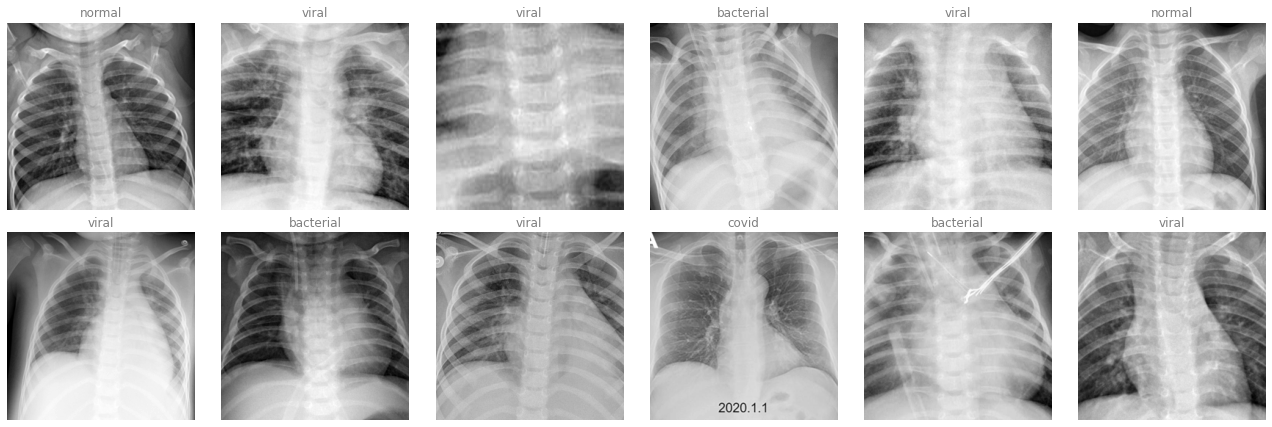

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=6, figsize=(18,6))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(x_train[i], cmap='gray')
    ax.set_title(num2labels[y_train_num[i]], color='gray')
    ax.set_axis_off()
plt.tight_layout()

class proportions: 
{'bacterial': 0.3105590062111801,
 'covid': 0.06832298136645963,
 'normal': 0.3105590062111801,
 'viral': 0.3105590062111801}


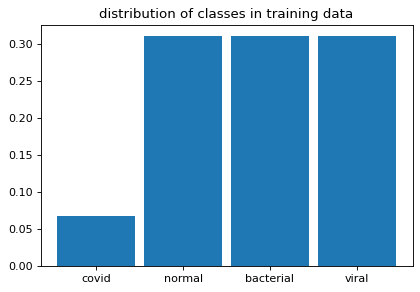

In [9]:
fig, ax = plt.subplots(dpi=80)
h = ax.hist(y_train_num, np.linspace(-0.5, n_classes-0.5, n_classes+1),
            density=True, rwidth=0.9)
ax.set_xticks(np.arange(n_classes))
ax.set_xticklabels([num2labels[i] for i in range(n_classes)])
ax.set_title('distribution of classes in training data')

train_class_proportions = h[0]
print('class proportions: ')
pprint({num2labels[i]: train_class_proportions[i] for i in range(n_classes)})

In [10]:
# class weights
w_class = {i: train_class_proportions[i] for i in range(n_classes)}
w_class[labels2num['covid']] = train_class_proportions[labels2num['covid']]*5  # weight COVID class more highly
w_class

{0: 0.34161490683229817,
 1: 0.3105590062111801,
 2: 0.3105590062111801,
 3: 0.3105590062111801}

## Image contrast enhancement

In [0]:
if True:
    ### apply contrast enhancement ###

    # training images
    for i in range(n_train):
        ce = PIL.ImageEnhance.Contrast(
                PIL.Image.fromarray(np.uint8(255*x_train[i])))
        x_train[i] = ce.enhance(1.5)

    # testing images
    for i in range(n_test):
        ce = PIL.ImageEnhance.Contrast(
                PIL.Image.fromarray(np.uint8(255*x_test[i])))
        x_test[i] = ce.enhance(1.5)

## Augment data of the 'covid' class

In [13]:
num2labels

{0: 'covid', 1: 'normal', 2: 'bacterial', 3: 'viral'}

In [14]:
idx_covid = np.where(y_train_labels == 'covid')[0]

np.random.seed(1)
covid_extra = []
for i, n in enumerate(idx_covid):
    for j in range(3 + (i+1)%2):
        r = 294 + 2*np.random.randint(5+1)  # size to resize the image to, before rotating&cropping
        angle = float(2*np.random.randint(2)-1) * np.round(np.random.rand()*4 + 2)
        shift_x = int(np.floor(np.random.rand()*4 - 2))
        shift_y = int(np.floor(np.random.rand()*4 - 2))
        #print((r, angle, shift_x, shift_y))

        s0 = (r - 256) // 2
        s1 = s0 + 256
        covid_extra.append(
            x_train_orig[n].resize((r, r), resample=PIL.Image.BICUBIC)\
                           .rotate(angle, resample=PIL.Image.BICUBIC)\
                           .crop((s0+shift_x, s0+shift_y, s1+shift_x, s1+shift_y)))
        #print(' ', (22+shift_x, 22+shift_y, 278+shift_x, 278+shift_y))

len(covid_extra) + len(idx_covid)

347

In [0]:
# convert to array
covid_extra_np = np.zeros((len(covid_extra), *x_train[0].shape))
for i, img in enumerate(covid_extra):
    covid_extra_np[i] = img
covid_extra_np /= 255.0

covid_onehot = np.zeros((len(covid_extra), 4))
covid_onehot[:,labels2num['covid'] ] = 1

# append to training data
x_train2 = np.r_[x_train, covid_extra_np]
y_train2 = np.r_[y_train, covid_onehot]
n_train2 = n_train + len(covid_extra)

In [16]:
y_train2.shape, n_train2

((1397, 4), 1397)

In [0]:
# fig, ax = plt.subplots(ncols=2, figsize=(11, 5))
# ax[0].imshow(x_train_orig[idx_covid[0]].resize((256, 256), resample=PIL.Image.BICUBIC), cmap='gray')
# ax[1].imshow(covid_extra[0], cmap='gray')

# ax[1].imshow(covid_extra[0])
# img = x_train_orig[idx_covid[0]].resize((294, 294), resample=PIL.Image.BICUBIC)
# ax[1].imshow(img.rotate(8, resample=PIL.Image.BICUBIC)\
#                 .crop((15, 15, 277, 277)), cmap='gray')
# img.rotate(8, resample=PIL.Image.BICUBIC, expand=True).crop((15, 15, 277, 277)).size
# np.array(x_train_orig[idx_covid[1]]\
#              .resize((314, 314), resample=PIL.Image.BICUBIC)\
#              .rotate(-8, resample=PIL.Image.BICUBIC)).shape

## Split the data into training and cross-validation sets

In [18]:
# split the data into training and cross-validation sets
# (0.8% for training and the remainder for the cross-validation set)

np.random.seed(0)
n_train_train = int(0.8*n_train2)
idx = np.random.permutation(n_train2)

if True:
    ### WITH data augmentation ###
    x_train_train, x_train_cv = np.split(x_train2[idx], [n_train_train])
    y_train_train, y_train_cv = np.split(y_train2[idx], [n_train_train])
    n_train_cv = x_train_cv.shape[0]

    print(f'Total training images {n_train2} (augmented) split into: '
        f'{n_train_train} training + {n_train_cv} cross-validation')
    
else:
    ### WITHOUT data augmentation ###
    x_train_train, x_train_cv = np.split(x_train[idx], [n_train_train])
    y_train_train, y_train_cv = np.split(y_train[idx], [n_train_train])
    n_train_cv = x_train_cv.shape[0]
    
    print(f'Total training images {n_train} split into: '
        f'{n_train_train} training + {n_train_cv} cross-validation')

# add the channel dimension required by keras
x_train_train = x_train_train.reshape((-1, *x_train[0].shape, 1))
x_train_cv = x_train_cv.reshape((-1, *x_train[0].shape, 1))

Total training images 1397 (augmented) split into: 1117 training + 280 cross-validation


[273. 274. 283. 287.] <--> [74. 76. 67. 63.]


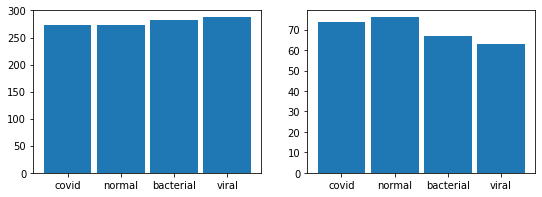

In [19]:
# check proportions of classess in training and cv sets
fig, ax = plt.subplots(ncols=2, figsize=(9,3))
h0 = ax[0].hist(np.where(y_train_train>0)[1], np.linspace(-0.5, n_classes-0.5, n_classes+1), rwidth=0.9)
ax[0].set_xticks(np.arange(n_classes))
ax[0].set_xticklabels([num2labels[i] for i in range(n_classes)])
h1 = ax[1].hist(np.where(y_train_cv>0)[1], np.linspace(-0.5, n_classes-0.5, n_classes+1), rwidth=0.9)
ax[1].set_xticks(np.arange(n_classes))
ax[1].set_xticklabels([num2labels[i] for i in range(n_classes)])
print(h0[0], '<-->', h1[0])

# Learn a CNN model

In [20]:
np.min(x_train2), np.max(x_train2)

(0.0, 255.0)

In [0]:
np.random.seed(0)
set_seed(0)  # set TF's random seed

# define the CNN
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same',
                 input_shape=list(x_train[0].shape)+[1]))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
# model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
# model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(n_classes, activation='softmax'))

In [22]:
# set up the optimizer and compile model
learning_rate = 1e-4
batch_size = 32
max_epochs = 200

optimizer = keras.optimizers.Nadam(learning_rate)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=optimizer,
              metrics=['accuracy'])

# set up early-stopping
callbacks = [keras.callbacks.callbacks.EarlyStopping(monitor='val_loss',
                                                     patience=10, verbose=1,
                                                     restore_best_weights=True)]
                                                     
# train the neural net
history = model.fit(x_train_train, y_train_train,
                    class_weight=w_class,
                    batch_size=batch_size,
                    epochs=max_epochs,
                    verbose=1,
                    validation_data=(x_train_cv, y_train_cv),
                    callbacks=callbacks)

Train on 1117 samples, validate on 280 samples
Epoch 1/200
1117/1117 [==============================] - 8s 7ms/step - loss: 1.1577 - accuracy: 0.3295 - val_loss: 1.0618 - val_accuracy: 0.6429
Epoch 2/200
1117/1117 [==============================] - 1s 1ms/step - loss: 0.4193 - accuracy: 0.5560 - val_loss: 1.0125 - val_accuracy: 0.7000
Epoch 3/200
1117/1117 [==============================] - 1s 1ms/step - loss: 0.3473 - accuracy: 0.6285 - val_loss: 0.8778 - val_accuracy: 0.6929
Epoch 4/200
1117/1117 [==============================] - 1s 1ms/step - loss: 0.3097 - accuracy: 0.6374 - val_loss: 0.7419 - val_accuracy: 0.7500
Epoch 5/200
1117/1117 [==============================] - 1s 1ms/step - loss: 0.2547 - accuracy: 0.6822 - val_loss: 0.6354 - val_accuracy: 0.7714
Epoch 6/200
1117/1117 [==============================] - 1s 1ms/step - loss: 0.2159 - accuracy: 0.6974 - val_loss: 0.5633 - val_accuracy: 0.7679
Epoch 7/200
1117/1117 [==============================] - 1s 1ms/step - loss: 0.2042

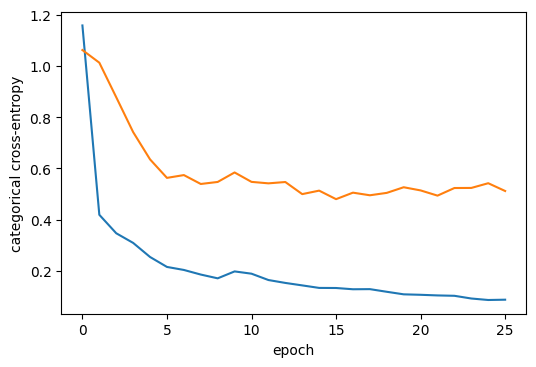

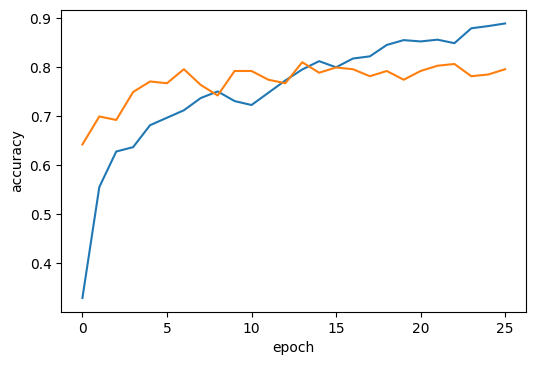

In [23]:
# plot learning curves
plt.figure(figsize=(6,4), dpi=100)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='cross-validation loss')
plt.ylabel('categorical cross-entropy')
plt.xlabel('epoch')

plt.figure(figsize=(6,4), dpi=100)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='cross-validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch');

In [0]:
# # plot learning curves
# fig, ax = plt.subplots(ncols=2, figsize=(11,4))

# ax[0].plot(history.history['loss'], label='training loss')
# ax[0].plot(history.history['val_loss'], label='cross-validation loss')
# ax[0].set_ylabel('categorical cross-entropy')
# ax[0].set_xlabel('epoch')

# ax[1].plot(history.history['accuracy'], label='training accuracy')
# ax[1].plot(history.history['val_accuracy'], label='cross-validation accuracy')
# ax[1].set_ylabel('accuracy')
# ax[1].set_xlabel('epoch');

array([0.81441504, 0.80639555, 0.79325921, 0.81043478, 0.81668994,
       0.79721739, 0.80034843, 0.79881862, 0.82551269, 0.79693487,
       0.82178907, 0.80709072, 0.80403058, 0.79309142, 0.80404463,
       0.78586351, 0.81786583, 0.81089521, 0.81758394, 0.832     ,
       0.79701078, 0.81471201, 0.79979109, 0.81126173, 0.79643855,
       0.75782881, 0.77013889, 0.84628791, 0.80410578, 0.86433033,
       0.80383275, 0.79972184, 0.77310632, 0.81374259, 0.76952447])

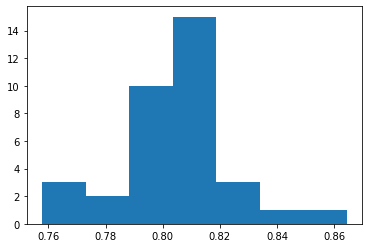

In [25]:
from sklearn.metrics import accuracy_score

covid_classnum = labels2num['covid']
K = 35
acc = np.zeros(K)
for k in range(K):
    ii = np.random.randint(n_train_cv, size=n_train_cv)
    w = np.array([5*train_class_proportions[i] if i == covid_classnum  else
                  train_class_proportions[i] for i in np.where(y_train_cv[ii, :])[1]])
    py = model.predict(x_train_cv[ii,:].reshape((-1, *x_train[0].shape, 1)))
    # print(y_train_cv[ii,:].shape, py.shape)
    acc[k] = accuracy_score(np.argmax(y_train_cv[ii,:], axis=1),
                            np.argmax(py, axis=1), sample_weight=w)

plt.hist(acc, 7)
acc

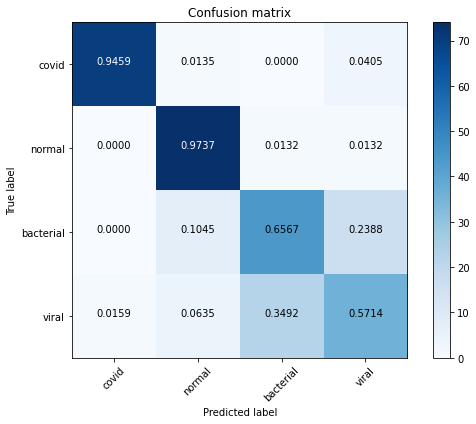

In [32]:
from sklearn.metrics import confusion_matrix

# estimate the confusion matrix
py = model.predict(x_train_cv.reshape((-1, *x_train[0].shape, 1)))
cf_mtx = confusion_matrix(np.argmax(y_train_cv, axis=1), np.argmax(py, axis=1))

# plot it
plt.figure(figsize=(8, 6))
plt.imshow(cf_mtx, interpolation='nearest', cmap='Blues')
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()

tick_marks = np.arange(n_classes)
class_names = [num2labels[i] for i in range(n_classes)]
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

cf_mtx_norm = cf_mtx.astype('float') / cf_mtx.sum(axis=1)[:, np.newaxis]
thresh = 0.8*cf_mtx_norm.max()
for i in range(n_classes):
    for j in range(n_classes):
        plt.text(j, i, "{:0.4f}".format(cf_mtx_norm[i, j]),
                 horizontalalignment="center",
                 color="white" if cf_mtx_norm[i, j] > thresh else "black")

plt.tight_layout()

# Classify test images

In [0]:
# classify test images
py_test = model.predict(x_test.reshape((-1, *x_test[0].shape, 1)))

In [0]:
yhat = np.argmax(py_test, axis=1)
yhat_labels = [num2labels[c] for c in yhat]

In [0]:
# fid = datetime.datetime.now().strftime('%Y%m%dT%H%M%S')

# # save cnn configuration and learning parameters
# fn = basedir + '/config_' + fid + '.txt'
# with open(fn, 'w') as fh:
#     pprint(history.params, stream=fh)      # batchsize, epochs, etc.
#     pprint(history.model.optimizer.get_config(), stream=fh)   # learning rate
#     pprint(model.get_config(), stream=fh)  # info on all the layers

# # generate submission file
# fn = basedir + '/submission_' + fid + '.csv'
# pd.DataFrame(yhat_labels, columns=['label']).to_csv(fn, index_label='Id')

In [0]:
k = np.arange(20)
plt.plot(2*k*((1-0.55)**k))